In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

import sys
sys.path.append('.')

import banc_loading as banc_loading
print('version', banc_loading.dataset_version)
meta_table = banc_loading.META_TABLE

version 626


In [2]:
meta_table['super_class'].value_counts()

super_class
optic_lobe_intrinsic              27684
central_brain_intrinsic           20957
sensory                           13886
ventral_nerve_cord_intrinsic      12432
visual_projection                  5662
ascending                          1841
descending                         1313
motor                               833
sensory_ascending                   511
visual_centrifugal                  434
visceral_circulatory                188
sensory_descending                   13
ascending_visceral_circulatory        5
glia, trachea                         4
Name: count, dtype: int64

## Get Neurons

In [3]:
def assign_colors(array, cmap_name='plasma', symmetrize=False):
    # Normalize the array between 0 and 1
    if symmetrize:
        norm = array / np.abs(array).max()
        norm = (norm + 1) / 2 
    else:
        norm = (array - np.min(array)) / (np.max(array) - np.min(array))
    
    # Get the colormap
    cmap = cm.get_cmap(cmap_name)
    
    # Apply colormap to normalized values
    colors = cmap(norm)
    
    return colors

In [4]:
meta_table['clustering_set'] = None
for region in meta_table['region'].unique():
    if region == 'optic_lobe' or region == 'brain' or region is None:
        continue
    print(region)
    mask = meta_table['region'] == region
    for ex in ['sensory', 'motor', 'efferent', 'afferent', 'visceral']:
        mask &= (meta_table['super_class'].str.contains(ex) != True)
    meta_table.loc[mask, 'clustering_set'] = region
mask = meta_table['super_class'].isin(['visual_centrifugal', 'visual_projection'])
meta_table.loc[mask, 'clustering_set'] = 'visual'

central_brain
neck_connective
ventral_nerve_cord


In [5]:
values = ['central_brain', 'neck_connective', 'ventral_nerve_cord', 'visual']
min_weight = 1

matrix, elist = banc_loading.get_full_connectivity_filtered(col='clustering_set', values=values, min_weight=min_weight)

113851
113818
113817
51502


In [6]:
ids = matrix.index.values
influence_matrix = matrix.sparse.to_coo().astype(np.float32)
influence_matrix = influence_matrix / influence_matrix.sum(0)

influence_matrix = .5 * (influence_matrix + influence_matrix.T)
influence_matrix = influence_matrix.astype(np.float32)

In [7]:
total = 0
value_counts = meta_table.loc[ids, 'super_class'].value_counts()
for super_class, value_count in value_counts.items():
    print(super_class, value_count, (meta_table['super_class'] == super_class).sum())
    total += value_count
    # excluded_members = meta_table.loc[(meta_table['super_class'] == super_class) & ~meta_table['id'].isin(ids)]
    # cell_type_breakdown = excluded_members['cell_type'].value_counts()
    # for cell_type, count in cell_type_breakdown.items():
    #     if count < 5:
    #         continue
    #     print(cell_type, count)
print(total)

central_brain_intrinsic 20404 20957
ventral_nerve_cord_intrinsic 12387 12432
visual_projection 5597 5662
ascending 1834 1841
descending 1311 1313
visual_centrifugal 418 434
41951


In [9]:
value_counts = meta_table.loc[ids, 'super_class'].value_counts()
for super_class, value_count in value_counts.items():
    if super_class == 'visual_projection':
        continue
    print(super_class, value_count, (meta_table['super_class'] == super_class).sum())
    excluded_members = meta_table.loc[(meta_table['super_class'] == super_class) & ~meta_table['id'].isin(ids)]
    cell_type_breakdown = excluded_members['cell_type'].value_counts()
    for cell_type, count in cell_type_breakdown.items():
        print(cell_type, count)

central_brain_intrinsic 20404 20957
OCI 15
vDeltaA,vDeltaB,vDeltaC,vDeltaD,vDeltaE,vDeltaJ,vDeltaK,vDeltaL,vDeltaM 12
PFNm,PFNp 10
KCg-m 9
vDeltaF,vDeltaG,vDeltaH,vDeltaI 8
PVLP112b 7
WEDPN6B, WEDPN6C 6
CB1155 6
FS4A,FS4B,FS4C 6
PLP156 6
FC1D,FC1E 5
PLP150c 5
columnar 5
WEDPN6A 5
DN1a 4
PLP231 4
AVLP486 4
KCab 4
FC2C 4
CB1258 4
PLP158 4
FS1A,FS1B 4
KCab-p 3
CL254 3
l-LNv 3
CB1242 3
AVLP558 3
PLP241 3
CB1329 3
CL252 3
CB3866 3
CB1406 3
FC1C 3
mALC6 3
FC3 3
CB3861 2
AVLP559a 2
CB2194 2
MBON16 2
CB1067 2
CB1380 2
CB1959 2
AVLP547b 2
FS2 2
CB2979 2
CB2287 2
FB2M 2
LAL094 2
AVLP151 2
CB.FB6C0 2
PVLP108 2
PLP181 2
CB1154 2
CB0802 2
PLP185,PLP186 2
VLPl&p2_posterior_38 2
PLP150b 2
5-HTPMPV01 2
aMe24 2
LAL047 2
PLP051 2
PAM08 2
CB2671 2
PLP215 2
CB1617 2
CL255 2
aMe13 2
PLP032 2
PLP159 2
CB0793 2
CB2685 2
AVLP559b 2
PLP160 2
PVLP113 2
CB2766 2
CB1395 2
AVLP560 2
AVLP541a 2
LNd_a 2
CB1231 2
mAL 2
CB2116 2
CB1471 2
CB.FB2E10 2
CB1791 2
CB3860 2
SMP538,SMP599 2
APDN3 2
CB2463 2
CB2577 2
SMP104,SM

## Load Skeletons for Later Visualization

In [10]:
import os
from pathlib import Path
import warnings
import open3d as o3d

def plot_helper(*args, title='', c=None):
    plt.scatter(*args, s=1, c=c)
    plt.gca().set_aspect('equal')
    plt.title(title)
    plt.show()

def read_swc(path):
    column_names = ['node_id', 'node_type', 'x', 'y', 'z', 'radius', 'node_parent_id']
    
    # Read the SWC file, skipping comment lines that start with '#'
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', FutureWarning)
        skel_df = pd.read_csv(path, 
                             comment='#',        # skip comment lines
                             delim_whitespace=True,  # handle space or tab delimiters
                             names=column_names)
    return skel_df

def draw_point_cloud(x, y, z, colors=None):
    # Example point cloud
    pcd = o3d.geometry.PointCloud()

    points = np.stack([x, y, z], -1)
    pcd.points = o3d.utility.Vector3dVector(points)
    
    if colors is not None:
        pcd.colors = o3d.utility.Vector3dVector(colors)
        
    # For inline visualization (Jupyter support)
    o3d.visualization.draw_geometries([pcd])

skel_dir = Path('banc_skeletons')
num_skip = 0
skel_dfs = []

for id in ids:
    swc_path = f'banc_skeletons/{id}.swc'
    if not os.path.exists(swc_path):
        continue
    
    skel_df = read_swc(swc_path)
    skel_df['id'] = id
    skel_dfs.append(skel_df)

length = sum(skel_df.shape[0] for skel_df in skel_dfs)
skel_dfs = pd.concat(skel_dfs)

## UMAP Embedding

In [11]:
import umap

def perform_umap_embedding(data, n_neighbors=10, metric='cosine', random_state=None, min_dist=0.1, n_components=2):
    # Initialize UMAP model with parameters
    umap_model = umap.UMAP(n_neighbors=n_neighbors, 
                           metric=metric,
                           random_state=random_state,
                           min_dist=0, n_components=2, n_jobs=1)
    
    # Perform the embedding
    embedding = umap_model.fit_transform(data)
    
    return embedding

def overlay(embedding, mask, title, alpha=.1):
    plt.title(title)
    plt.scatter(*embedding.T, s=1, c='black', alpha=alpha)
    plt.scatter(*embedding[mask].T, s=5, c='red')
    plt.gca().axis('off')
    plt.gca().set_aspect('equal')
    plt.show()

def overlay_by_val(embedding, ids, col, val, min_val=-np.inf, alpha=.1):
    if val == '':
        return
    mask = meta_table.loc[ids, col] == val
    mask = (mask == True).values # avoid nans
    if mask.sum() >= min_val:
        overlay(embedding, mask, f'{col}_{val}', alpha=alpha)

def iter_over_vals(embedding, ids, col, vals=None, min_val=10, alpha=.1):
    if vals is None:
        vals = meta_table[col]
        vals = vals[~vals.isnull()]
        vals = sorted(vals.unique())
    for val in vals:
        overlay_by_val(embedding, ids, col, val, min_val, alpha=alpha)

def iter_over_sides(embedding, ids, col, min_val=10, alpha=.1):
    vals = ['left', 'right', 'center']
    colors = ['red', 'blue', 'teal']
    for val, color in zip(vals, colors):
        mask = meta_table.loc[ids, col] == val
        mask = (mask == True).values # avoid nans
        # if val == 'center':
        #     alpha = 1
        plt.scatter(*embedding[mask].T, s=5, c=color, label=val, alpha=alpha)
    # plt.xlim(None, 9)
    # plt.ylim(0, None)
    plt.gca().set_aspect('equal')
    plt.gca().axis('off')
    plt.show()

In [12]:
# n_neighbors = 20 # 20 # 100
# print(n_neighbors)
# metric = 'cosine'
# random_state = 0
# embedding = perform_umap_embedding(influence_matrix, n_neighbors, metric, random_state)
embedding = np.zeros((len(ids), 2))

# iter_over_sides(embedding, ids, 'side', alpha=.05)

In [13]:
# col = 'super_class'
# iter_over_vals(embedding, ids, col)

### Spectral Clustering

In [14]:
import numpy as np
from scipy.sparse import coo_matrix, csgraph
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.sparse.linalg import eigsh


def spectral_clustering_from_coo(coo_adj, num_clusters, random_state=None, feature_dimension=None):
    """
    Perform spectral clustering on a graph given as a COO adjacency matrix.

    Parameters:
    - coo_adj: scipy.sparse.coo_matrix representing the adjacency matrix of the graph
    - num_clusters: number of communities to find

    Returns:
    - labels: array of community assignments
    """
    if feature_dimension is None:
        feature_dimension = num_clusters

    # Step 1: Compute the Laplacian
    laplacian = csgraph.laplacian(coo_adj, normed=True)

    # Step 2: Compute the first k eigenvectors of the Laplacian
    eigval, eigvec = eigsh(laplacian, k=feature_dimension, which='SM')

    # Step 3: Normalize the rows (each row is a point in R^k)
    embedding = normalize(eigvec)

    # Step 4: Run k-means on the rows of the eigenvector matrix
    kmeans = KMeans(n_clusters=num_clusters, random_state=random_state)
    labels = kmeans.fit_predict(embedding) + 1

    return labels, embedding 


n_clusters = 13
# 3 4 5 12
clustering_random_state = 10

unordered_spectral_clusters, eig_embedding = spectral_clustering_from_coo(influence_matrix, n_clusters, clustering_random_state)

cmap = plt.get_cmap('tab20', 20)
# for i in np.unique(unordered_spectral_clusters):
#     mask = unordered_spectral_clusters == i
#     plt.scatter(*embedding[mask].T, s=1, alpha=.5, label=i, color=cmap(i - 1))
# plt.gca().set_aspect('equal')
# plt.title('unordered clusters')
# plt.legend()
# plt.show()

In [15]:
n_neighbors = 100 # 20 # 100
print(n_neighbors)
metric = 'cosine'
# 3 4 5
embedding_random_state = 3
eig_umap_embedding = perform_umap_embedding(eig_embedding, n_neighbors, metric, embedding_random_state)

100


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


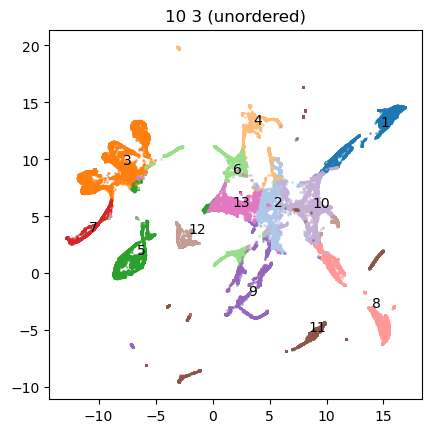

In [16]:
plot_embedding = eig_umap_embedding
for i in np.unique(unordered_spectral_clusters):
    mask = unordered_spectral_clusters == i
    plt.scatter(*plot_embedding[mask].T, s=1, alpha=.5, label=i, color=cmap(i - 1))
    plt.annotate(i, np.median(plot_embedding[mask], 0))
plt.gca().set_aspect('equal')
plt.title(f'{clustering_random_state} {embedding_random_state} (unordered)')
plt.show()

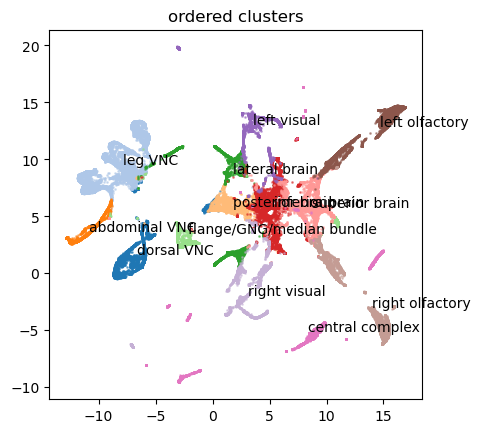

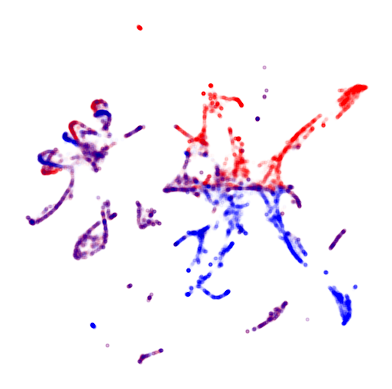

In [17]:
mapping = {v: k for k, v in {
    1: 5,
    2: 3,
    3: 7,
    4: 13,
    5: 6,
    6: 12,
    7: 2,
    8: 10,
    9: 4,
    10: 9,
    11: 1,
    12: 8,
    13: 11
}.items()}

cluster_names = {
    1: 'dorsal VNC',
    2: 'leg VNC',
    3: 'abdominal VNC',
    4: 'posterior brain',
    5: 'lateral brain',
    6: 'flange/GNG/median bundle',
    7: 'inferior brain',
    8: 'superior brain',
    9: 'left visual',
    10: 'right visual',
    11: 'left olfactory',
    12: 'right olfactory',
    13: 'central complex'
}

# mapping = cluster_names = {i: i for i in range(1, n_clusters + 1)}

spectral_clusters = np.array([mapping[i] for i in unordered_spectral_clusters])
meta_table.loc[ids, 'spectral_cluster'] = spectral_clusters

plot_embedding = eig_umap_embedding
for i in np.unique(spectral_clusters):
    mask = spectral_clusters == i
    plt.scatter(*plot_embedding[mask].T, s=1, alpha=.5, label=cluster_names[i], color=cmap(i - 1))
    plt.annotate(cluster_names[i], np.median(plot_embedding[mask], 0))
# plt.legend()
plt.gca().set_aspect('equal')
plt.title('ordered clusters')
plt.show()

iter_over_sides(plot_embedding, ids, 'side', alpha=.01)
# iter_over_vals(plot_embedding, ids, 'super_class')

In [18]:
clustered_meta = pd.DataFrame(index=ids)
clustered_meta.loc[ids, 'spectral_cluster'] = spectral_clusters
clustered_meta.loc[ids, 'umap_x'] = plot_embedding[:, 0]
clustered_meta.loc[ids, 'umap_y'] = plot_embedding[:, 1]
clustered_meta['unofficial_cluster_name'] = clustered_meta['spectral_cluster'].map(cluster_names)
clustered_meta.to_csv(f'spectral_clustering_min_connection_strength_{min_weight}_banc_version_{banc_loading.dataset_version}_cluster_count_{n_clusters}_cluster_seed_{clustering_random_state}_embedding_seed_{embedding_random_state}.csv')

### Visualization

In [19]:
skel_dfs['spectral_cluster'] = skel_dfs['id'].map(meta_table['spectral_cluster'])

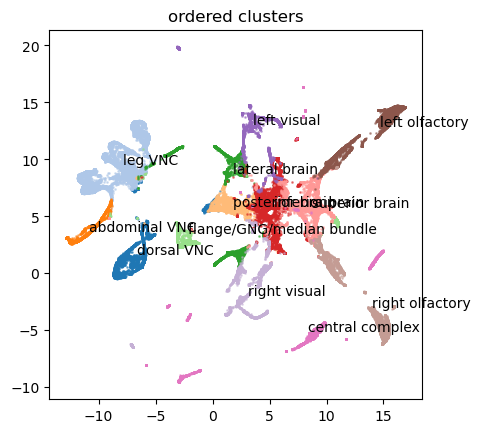

In [20]:
for i in np.unique(spectral_clusters):
    mask = spectral_clusters == i
    plt.scatter(*plot_embedding[mask].T, s=1, alpha=.5, label=i, color=cmap(i - 1))
    plt.annotate(cluster_names[i], np.median(plot_embedding[mask], 0))
plt.gca().set_aspect('equal')
plt.title('ordered clusters')
plt.show()

In [21]:
for cluster in range(1, n_clusters + 1):
    cluster_df = skel_dfs.loc[skel_dfs['spectral_cluster'] == cluster]
    x, y, z = cluster_df['x'].values, cluster_df['y'].values, cluster_df['z'].values
    # colors = np.full

    c = np.array(cmap(cluster - 1))
    c = c[None, :3]
    c = np.broadcast_to(c, (len(x), 3))
    draw_point_cloud(x, y, z, c)

In [22]:
cs = []
points = []
for cluster in range(1, n_clusters + 1):
    cluster = int(cluster)
    cluster_df = skel_dfs.loc[skel_dfs['spectral_cluster'] == cluster]
    x, y, z = cluster_df['x'].values, cluster_df['y'].values, cluster_df['z'].values
    # colors = np.full

    c = np.array(cmap(cluster - 1))
    c = c[None, :3]
    c = np.broadcast_to(c, (len(x), 3))
    cs.append(c)
    points.append(np.stack((x, y, z), -1))
cs = np.concatenate(cs, 0)
points = np.concatenate(points, 0)
draw_point_cloud(*points.T, cs)

In [23]:
cs = []
points = []
for cluster in [9, 10]:
    cluster = int(cluster)
    cluster_df = skel_dfs.loc[skel_dfs['spectral_cluster'] == cluster]
    x, y, z = cluster_df['x'].values, cluster_df['y'].values, cluster_df['z'].values
    # colors = np.full

    c = np.array(cmap(cluster - 1))
    c = c[None, :3]
    c = np.broadcast_to(c, (len(x), 3))
    cs.append(c)
    points.append(np.stack((x, y, z), -1))
cs = np.concatenate(cs, 0)
points = np.concatenate(points, 0)
draw_point_cloud(*points.T, cs)

In [24]:
for cluster in [9, 10]:
    cluster_df = skel_dfs.loc[skel_dfs['spectral_cluster'] == cluster]
    x, y, z = cluster_df['x'].values, cluster_df['y'].values, cluster_df['z'].values
    # colors = np.full

    c = np.array(cmap(cluster - 1))
    c = c[None, :3]
    c = np.broadcast_to(c, (len(x), 3))
    draw_point_cloud(x, y, z, c)

In [25]:
for cluster in range(1, n_clusters + 1):
    print(cluster, cluster_names[cluster], (meta_table['spectral_cluster'] == cluster).sum())
    print(meta_table.loc[meta_table['spectral_cluster'] == cluster, 'super_class'].value_counts())
    print()

1 dorsal VNC 4036
super_class
ventral_nerve_cord_intrinsic    2635
descending                       525
ascending                        467
central_brain_intrinsic          269
visual_centrifugal                 5
visual_projection                  1
Name: count, dtype: int64

2 leg VNC 9781
super_class
ventral_nerve_cord_intrinsic    8098
ascending                        859
descending                       430
central_brain_intrinsic          118
Name: count, dtype: int64

3 abdominal VNC 1601
super_class
ventral_nerve_cord_intrinsic    1195
ascending                        101
descending                        57
Name: count, dtype: int64

4 posterior brain 3168
super_class
central_brain_intrinsic    2042
visual_projection           130
descending                  114
ascending                    49
visual_centrifugal           44
Name: count, dtype: int64

5 lateral brain 4098
super_class
central_brain_intrinsic         2300
ventral_nerve_cord_intrinsic     458
ascending          